# Working with Time-Series Data in a Consistent Bayesian Framework
---

Copyright 2017 Michael Pilosov


### Import Libraries
_(should be 2.7 and 3.x compatible) _

In [1]:
# Mathematics and Plotting
from HelperFuns import * # pyplot wrapper functions useful for visualizations, numpy, scipy, etc.
%matplotlib inline
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = 5, 5

# Interactivity
from ipywidgets import *

---
## Defining the Parameter to Observables (PtO) Map 

---
Consider the Ordinary Differential Equation Initival Value Problem given by  

$$
\partial_t u(t) = -u(t) \\
u(0) = \lambda_0
$$

The solution to this problem is $u(t) = \lambda_0 \,e^{-t}$.

Suppose $\lambda_0$ is some uncertain input parameter that we are trying to estimate through experimental observations. 

Suppose we know that $\lambda_0 \in [0, 2]$ with uniform probability and that we hope to infer the parameter by observing the system $u$ at K evenly spaced intervals in the interval $[T_0, T]$, where $T > T_0 > 0$. 

In order to define our Parameter-to-Observables Map, we want to transform these observations into a single measurement, which we do by looking at the **Mean Squared Error (2-norm) between the observations and the model predictions**:  

$$
O(\lambda) = \frac{1}{K} \sum_{k=1}^{K} \frac{(\lambda e^{-k\Delta_t} - \lambda_0e^{-k\Delta_t}) ^ 2}{\sigma_k^2} = \frac{1}{K}  \sum_{k=1}^{K} \frac{( (\lambda- \lambda_0) e^{-k\Delta_t} ) ^ 2 }{ \sigma_k^2}
$$
$$
= \frac{(\lambda- \lambda_0)^2}{K}  \sum_{k=1}^{K}  \left ( \frac{e^{-k\Delta_t}}{\sigma_k} \right )^2, \quad \text{where } \Delta_t\equiv T_0 + \frac{T - T_0}{K}
$$

Observe that the division of each measurement by a standard deviation is consistent with the formulation of an additive error statistical model familiar to the usual Bayesian formulation:  

$$
y_i = \beta\, x_i + \epsilon_i, \quad \epsilon_i \sim N(0,\sigma_i)
$$

Jump straight to the [Sandbox](#All-in-One-Sandbox!)

--- 

### Choose the Reference Parameter
_This is what we consider the "true" parameter we are trying to estimate_

In [2]:
lam0 = 0.5 # true / reference lambda_0

### Define the Experiment
- _Set the number of observations you will make, $K$_
- _Set the time $T_0$ of the first observation_
- _Set the end time $T$ of the last observation_
- _Define your confidence in each measurement (standard deviation)_

In [55]:
num_observations = 5 # number of measurements(K)
# if you specify 1, it will occur at T_0
T_start = 0.1 # first observation
T_end = 1 # last observation
# STANDARD DEVIATION FOR EACH MEASUREMENT.
sd = 1  # this makes it constant for all of them.
# if you want to specify them individually, replace the line below.
sigma = sd*np.ones(num_observations)

We now use these to construct the map, which we can evaluate by calling `PtO_fun` and passing it a 1-D vector `lambda`

In [15]:
t = np.linspace(T_start, T_end, int(num_observations))
def PtO_fun(lam):
    return ((lam - lam0)**2/num_observations)*np.sum( [ np.power(
        [ np.exp(-t[k])/sigma[k] ], 2)[0] 
        for k in range(int(num_observations))          ], 0 )

--- 

## Sample from $\Lambda$
_Here we implement uniform random prior on [0, 1], but you can load in any set of samples in its place._

In [16]:
num_samples = int(1E4)
input_dim = 1 # do not change. This is for plotting purposes. Unecessary in Sandbox.
lam = 2*np.random.uniform( size = (int(input_dim), int(num_samples)) ) # standard uniform

---
## Compute Data Space $O(\Lambda) = \mathcal{D}$ 

Format: `(n_dims, n_samples)`  
_Optional_: Specify subset of PtO map's components to use for inversion using the variable `sub_indices` 

In [17]:
D = PtO_fun(lam)
output_dim = D.shape[0] # This is for plotting purposes. Unecessary in Sandbox.
print('dimensions :  lambda = ' + str(lam.shape) + '   D = ' + str(D.shape) )

dimensions :  lambda = (1, 10000)   D = (1, 10000)


## Compute Push-Forward of the Prior $P_{O(\Lambda)}$
_ ... i.e. Visualize the Data Space_

In [18]:
# # Below you will find one-dimensional histogram option
# M = 100 # number of bins in the data space
# plt.hist(D[0],M)
# plt.title('histogram of data space')
# plt.show()

# Interactive Marginal Visualization
pf_dens = gkde(D) # compute KDE estimate of it
# Can plot "slices" of densities to observe differences between posterior and prior, but not that useful

a, b = -0.1, 1.25 # linspace parameters for plotting
plot_grid = np.linspace(a, b, 100)

interact(view_est_dens, x = fixed(plot_grid), 
         estimated_dens = fixed(pf_dens), 
         lab = fixed('KDE data'), title=fixed('Pushforward of Prior'),
         viewdim=(0, output_dim-1, 1) )

A Jupyter Widget

<function HelperFuns.view_est_dens>

## Define Observed Probability Measure $P_\mathcal{D}$

Since we have assumed an additive normal error model, our data should be distributed according to $d_i \sim \chi^2(K)$.  
We also include a uniform density on $[0,$ `M` $]$ which is akin to minimizing the MSE.

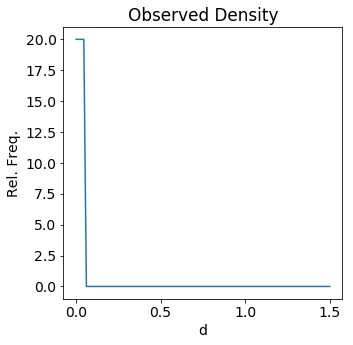

In [50]:
# obs_dens = sstats.chi2(num_observations)
a, b = 0, 1.5 # linspace parameters for plotting
plot_grid = np.linspace(a, b, 100)

# # Uniform Density
M = 0.05
obs_dens = sstats.uniform(0,M) # 1D only
# # A normal density in case you want to invert something else... 
# obs_dens = sstats.norm(0.5,sigma) # 1D only
plt.rcParams['figure.figsize'] = 5, 5
plt.plot(plot_grid,obs_dens.pdf(plot_grid))
# plt.title('Chi Sq, K = %d'%num_observations)
plt.title('Observed Density')
plt.ylabel('Rel. Freq.')
plt.xlabel('d')
plt.show()

---

At this point we have performed the computations we need to. We have evaluated the input points through our map and performed a KDE on them. It would be useful at this point to save this object and/or its evaluation at every point in the data space for later re-use. Doing so here would be an appropriate place. 

--- 

## Accept/Reject Sampling of Posterior (with Visualization)

Since we have already used the samples in our prior to compute the pushforward density, we can re-use these with an accept/reject algorithm to get a set of samples generated from the posterior according to the solution of the stochastic inverse problem as outlined in the Consistent Bayes formulation. 

In [31]:
accept_inds = []
# r = (1./obs_dens.pdf( D )) / pf_dens.evaluate(D) # RECIPRICAL CHI SQUARED. REGULAR IS BELOW.
r = obs_dens.pdf( D ) / pf_dens.evaluate(D) # vector of ratios evaluated at all the O(lambda)'s
M = np.max(r)
eta_r = r[0]/M

In [32]:
accept_inds = [i for i in range(num_samples) if eta_r[i] > np.random.uniform(0,1) ]
lam_accept = np.array([lam[i,accept_inds] for i in range(input_dim)])
num_accept = len(accept_inds)
print('Number accepted: %d = %2.2f%%'%(num_accept, 100*np.float(num_accept)/num_samples))

Number accepted: 3282 = 32.82%


### Visualize Accept/Reject samples

In [40]:
plt.rcParams['figure.figsize'] = 10, 5
interact(pltaccept, lam = fixed(lam), lam_accept = fixed(lam_accept), 
         N = (1, num_accept+1, 10), eta_r = fixed(eta_r), 
         i = (0, input_dim-1, 1), j = (0, input_dim-1, 1))
# You will visualize the accepted samples in a subset of size N of the input samples
plt.show()

A Jupyter Widget

### Visual Summary

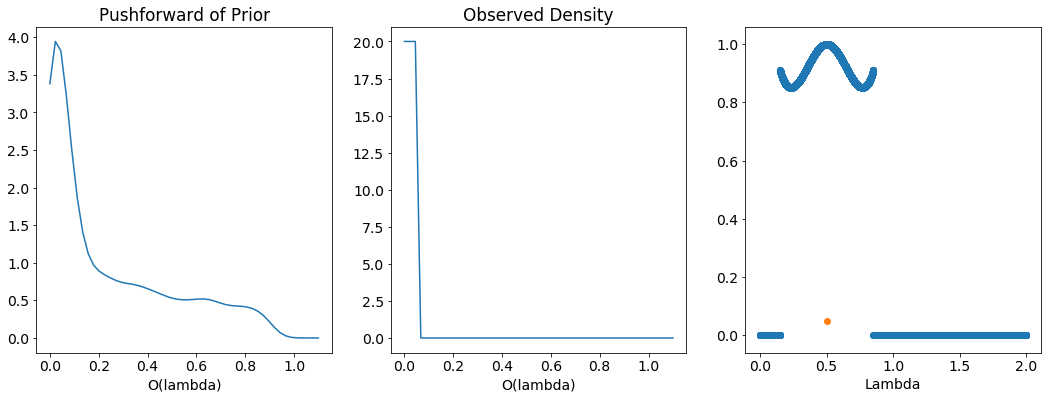

In [52]:
def plotstuff(lam, lam0, eta_r, res=50, max_x=1.1):
    plt.rcParams['figure.figsize'] = (18, 6)
    plt.figure()
    plt.subplot(1, 3, 1)
    x = np.linspace(0, max_x, res)
    plt.plot(x,pf_dens.evaluate(x))
    plt.title('Pushforward of Prior')
    plt.xlabel('O(lambda)')
    
    plt.subplot(1, 3, 2)
    xx = np.linspace(0, max_x, res)
    plt.plot(xx,obs_dens.pdf(xx))
    plt.title('Observed Density')
    plt.xlabel('O(lambda)')

    plt.subplot(1, 3, 3)
    plt.scatter(lam,eta_r)
    # plt.plot(lam_accept, gkde(lam_accept))
    plt.scatter(lam0, 0.05)
    # plt.title('Posterior Distribution\nof Uniform Observed Density \nwith bound = %1.2e'%uni_max)
    plt.xlabel('Lambda')
    # # OPTIONAL:
    # pr = 0.2 # percentage view-window around true parameter.
    # plt.xlim(lam0*np.array([1-pr,1+pr]))
    
    plt.show()

plotstuff(lam, lam0, eta_r, res=50, max_x=1.1)

Jump to [Extra Visualizations](#Extra-Visualizations) at the bottom of the worksheet to see the prior compared to the posterior as well as the pushforward of the posterior compared to the observed density. 

# All-in-One Sandbox!

In [117]:
def sandbox(num_observations=1, num_samples = int(1E4), lam0=0.5, 
            T_start=0.1, T_end=1, sd = 1):
    # NOTE this version only uses constant variances for the sake
    # of interactivity. 
    if num_observations == 1:
        print('K=1 specified, This is a single observation at t = %f.'%T_start)
    t = np.linspace(T_start, T_end, num_observations)
    def PtO_fun(lam):
        return ((lam - lam0)**2/num_observations)*np.sum( [ np.power(
            [ np.exp(-t[k])/sigma[k] ], 2)[0] 
            for k in range(int(num_observations))          ], 0 )
    
    # Sample the Parameter Space
    lam = 2*np.random.uniform( size = (1, int(num_samples)) ) # standard uniform
    # Map to Data Space
    D = PtO_fun(lam)
    print('dimensions :  lambda = ' + str(lam.shape) + '   D = ' + str(D.shape) )
    # Perform KDE to estimate the pushforward
    pf_dens = gkde(D) # compute KDE estimate of it
    # Specify Observed Measure - Uniform Density
    M = 0.05
    obs_dens = sstats.uniform(0,M) # 1D only
    # Solve the problem
    r = obs_dens.pdf( D ) / pf_dens.evaluate(D) # vector of ratios evaluated at all the O(lambda)'s
    M = np.max(r)
    eta_r = r[0]/M
    # Plot stuff
    plotstuff(lam, lam0, eta_r, res=50, max_x=1.1)



In [118]:
interact(sandbox, num_observations = [int(i) for i in np.linspace(1, 50, 50)], 
        num_samples = np.linspace(int(1E4), int(1E5), 201), 
        lam0 = np.linspace(0.25, 0.75, 21), 
        T_start = np.linspace(0.01, 0.99, 99), 
        T_end = np.linspace(1,11,51), 
        sd = np.linspace(0.25, 1.75, 16))

A Jupyter Widget

<function __main__.sandbox>

In [110]:
np.linspace(int(1E4), int(1E5), 201)

array([  10000.,   10450.,   10900.,   11350.,   11800.,   12250.,
         12700.,   13150.,   13600.,   14050.,   14500.,   14950.,
         15400.,   15850.,   16300.,   16750.,   17200.,   17650.,
         18100.,   18550.,   19000.,   19450.,   19900.,   20350.,
         20800.,   21250.,   21700.,   22150.,   22600.,   23050.,
         23500.,   23950.,   24400.,   24850.,   25300.,   25750.,
         26200.,   26650.,   27100.,   27550.,   28000.,   28450.,
         28900.,   29350.,   29800.,   30250.,   30700.,   31150.,
         31600.,   32050.,   32500.,   32950.,   33400.,   33850.,
         34300.,   34750.,   35200.,   35650.,   36100.,   36550.,
         37000.,   37450.,   37900.,   38350.,   38800.,   39250.,
         39700.,   40150.,   40600.,   41050.,   41500.,   41950.,
         42400.,   42850.,   43300.,   43750.,   44200.,   44650.,
         45100.,   45550.,   46000.,   46450.,   46900.,   47350.,
         47800.,   48250.,   48700.,   49150.,   49600.,   500

[Back to Top](#Choose-the-Reference-Parameter)

--- 

## Extra Visualizations

---
### Visualize Posterior Density

In [44]:
prior_dens_kde = gkde(lam)
post_dens_kde = gkde(lam_accept)

a, b = 0, 1 # linspace parameters for plotting
plot_grid = np.linspace(a, b, 100)

# Can plot "slices" of densities to observe differences between posterior and prior, but not that useful
interact(compare_est_input_dens, x = fixed(plot_grid), 
         estimated_dens1 = fixed(prior_dens_kde), estimated_dens2 = fixed(post_dens_kde), 
         lab_1 = fixed('KDE prior'), lab_2 = fixed('KDE post'), title=fixed(''),
         viewdim=(0, input_dim-1, 1))
plt.show()

A Jupyter Widget

## Visualize Quality of Solution 
_We compare the push-forward of the posterior using accepted samples against the observed density_

In [47]:
push_post_dens_kde = gkde([D[k][accept_inds] for k in range(output_dim)])

a, b = 0, 0.1 # linspace parameters for plotting
plot_grid = np.linspace(a, b, 100)

plt.rcParams['figure.figsize'] = (10, 5)
# diagonal crossection view
interact(compare_output_dens, x = fixed(plot_grid), 
         analytical_dens = fixed(obs_dens), estimated_dens = fixed(push_post_dens_kde), 
         lab_1 = fixed('observed'), lab_2 = fixed('KDE push'), title = fixed('Marginal - Observed v. PF'),
         viewdim = (0, output_dim-1, 1))
plt.show()

A Jupyter Widget